In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

Here - decoder: x -> sin(x)

In [85]:
def gen_xy(n=100):
    x = np.random.random([n,1,1]) # e.g. sin(y) + cos(x)
    return x, np.sin(x * np.pi * 2)

def gen_xy2(n=10):
    x_train = np.random.random((n,1))
    y = x_train > 0.5
    y_train = []
    for yy in y:
        if yy:
            y_train.append([1,0])
        else:
            y_train.append([0,1])
    return x_train, np.stack(y_train)
    
def gen_xy3(n=100):
    # x -> sin(x)
    xs = np.random.random((n,1))
    x_train = xs.reshape(n,1)
    range_ = 4 * np.pi # 0.5, * np.pi
    f = 1
    y_train = np.sin(x_train * range_ * f)
    return x_train, y_train

def gen_xy_sin_to_f(n_samples=100, n_t=100, f=2):
    # x_train = array (unique_samples, x_over_t, x)
    # y_train = array (unique_samples, x_over_t, sin(x))
    dt = 0.01
    phases = np.random.random(n_samples) * 2*np.pi
    timesteps = np.arange(n_t) * dt
    x_train = []
    y_train = []    
    for phase in phases:
        x_train.append(phase + timesteps)

    
    for phase in phases:
        y_train.append(sin_(n_t, f, phase))
    
    x_train = np.stack(x_train)
    x_train = x_train.reshape(n_samples, n_t, 1) 
    y_train = np.stack(y_train)
    y_train = y_train.reshape(n_samples, n_t, 1)
    return x_train, y_train
    
def sin_(n, f, phase=0, dt=0.01):
    ts = np.arange(n) * dt
    return np.sin(2*np.pi * f * ts + phase)

def sin_2(n, f, phase=0, dt=0.1):
    ts = np.arange(n) * dt
    results =  []
    for t in ts:
        t = np.sin(2*np.pi * f * t + phase)
        results.append([t])
    return np.stack(results)

In [86]:
n = 100
x_train, y_train = gen_xy_sin_to_f(n)
# x_train, y_train = gen_xy3(n)

x_test, y_test = gen_xy_sin_to_f(3)
print(x_train.shape, y_train.shape)

(100, 100, 1) (100, 100, 1)


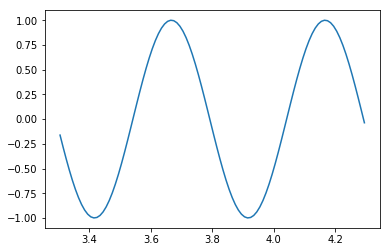

In [27]:
plt.plot(x_train[0], y_train[0])

In [28]:
# x_train = np.random.random((10,3))
# y_train = np.random.random((10,1))

In [29]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(100, 1)

In [30]:
output_shape

(100, 1)

In [135]:
def encoder(input_shape, output_shape):
#     input_layer = Input(shape=input_shape)
    # input shape = (None, None, 1)
    # thus: unfixed n samples, unfixed n timesteps, 1 float value
    input_layer = Input(shape=(None,1))
    x = input_layer
    
    hidden_size = 32
    xs = LSTM(hidden_size, return_state=True)(x)
    x = xs[0]
    print('dims x =', keras.backend.int_shape(x))
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='sigmoid')(x)
    x = Dense(100, activation='tanh')(x)
    x = Dense(100, activation='relu')(x)    
    
    x = Dense(np.prod(output_shape), activation='sigmoid')(x)
    x = Reshape(output_shape)(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

encoder = encoder(input_shape, output_shape)
encoder.summary()

dims x = (None, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_5 (LSTM)                [(None, 32), (None, 32),  4352      
_________________________________________________________________
dense_15 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1

In [136]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'adam'
encoder.compile(optimizer=optimizer, loss=loss, metrics=['mse'])#, metrics=metrics)

In [137]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 50

In [138]:
# decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
encoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 83 samples, validate on 17 samples
Epoch 1/50
83/83 [==============================] - 1s 9ms/step - loss: 0.6307 - mean_squared_error: 0.7195 - val_loss: 0.5447 - val_mean_squared_error: 0.6801
Epoch 2/50
83/83 [==============================] - 0s 5ms/step - loss: 0.4883 - mean_squared_error: 0.6556 - val_loss: 0.3838 - val_mean_squared_error: 0.6164
Epoch 3/50
83/83 [==============================] - 0s 5ms/step - loss: 0.3294 - mean_squared_error: 0.5960 - val_loss: 0.2023 - val_mean_squared_error: 0.5605
Epoch 4/50
83/83 [==============================] - 0s 5ms/step - loss: 0.1596 - mean_squared_error: 0.5466 - val_loss: 0.0230 - val_mean_squared_error: 0.5217
Epoch 5/50
83/83 [==============================] - 0s 5ms/step - loss: 9.8984e-04 - mean_squared_error: 0.5142 - val_loss: -0.1355 - val_mean_squared_error: 0.5002
Epoch 6/50
83/83 [==============================] - 0s 5ms/step - loss: -0.1518 - mean_squared_error: 0.4973 - val_loss: -0.3068 - val_mean_squared_err

In [139]:
x_test.shape

(3, 100, 1)

In [140]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [141]:
results = encoder.predict(x_test)
results.shape

(3, 100, 1)

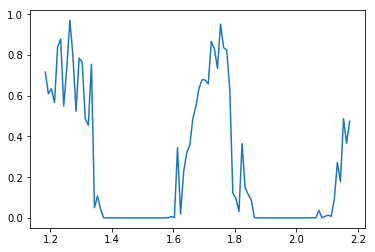

In [142]:
i = 0
plt.plot(x_test[i,:,0], results[i,:,0])

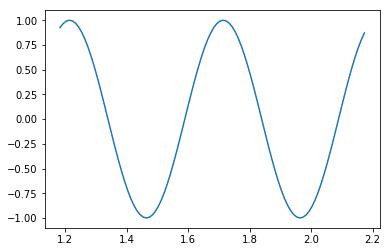

In [143]:
plt.plot(x_test[i,:,0], y_test[i,:,0])

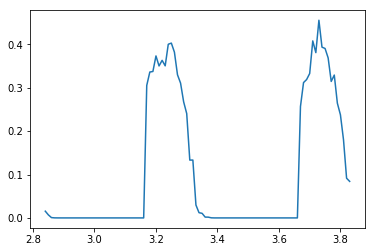

In [144]:
i = 2
plt.plot(x_test[i,:,0], results[i,:,0])

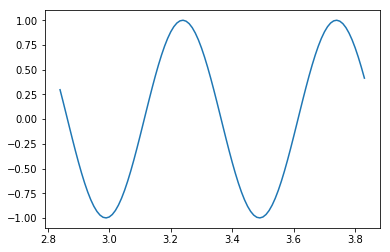

In [145]:
plt.plot(x_test[i,:,0], y_test[i,:,0])